In [1]:
import numpy as np
import pandas as pd
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, recall_score, \
                            classification_report, roc_auc_score, precision_score, \
                            f1_score, matthews_corrcoef, average_precision_score, \
                            precision_recall_curve, auc, roc_curve
from collections import Counter
%config Completer.use_jedi = False

In [2]:
def calc_stats(y_test, y_pred, X_test, clf):
    probs = clf.predict_proba(X_test)
    prob1 = probs[:, 1]
    stats_s = pd.Series(dtype='float')
    stats_s['recall'] = recall_score(y_test, y_pred)
    stats_s['prec'] = precision_score(y_test, y_pred)
    stats_s['MCC'] = matthews_corrcoef(y_test, y_pred)
    precision, recall, _ = precision_recall_curve(y_test, prob1, pos_label=1)
    stats_s['PR_AUC'] = auc(recall, precision)
    stats_s['avg_prec'] = average_precision_score(y_test, prob1)
    stats_s['roc_auc'] = roc_auc_score(y_test, prob1)
    
    return stats_s

In [3]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
def sample_data(X, y, samp_type, samp_strat, seed=0):
    if samp_type == 'over':
        sampler = RandomOverSampler(sampling_strategy=samp_strat, random_state=seed)
    elif samp_type == 'under':
        sampler = RandomUnderSampler(sampling_strategy=samp_strat, random_state=seed)
    else:
        print("Invalid 'samp_type'")
        
    # fit and apply the transform
    X_res, y_res = sampler.fit_resample(X, y)
    # summarize class distribution
    #print(Counter(y_res))
    #print(X_res.shape)
    
    return X_res, y_res

# Bootstrapped  random statistics runs

In [4]:
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
def bootstrap_stat(X, y, clf, nsamples=100, sample_weights=False, under=False, samp_strat=1.0):
    stats_df = pd.DataFrame()
    feat_imps_df = pd.DataFrame()
    for seed in range(nsamples):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=seed)
        #print(f'In bstrap(): y_train.shape = {y_train.shape}; X_train.shape = {X_train.shape}')
        #print(f'In bstrap(): np.bincount(y_train) = {np.bincount(y_train)}')

        if under:
            # Undersample the training data
            #print('Undersampling')
            X_res, y_res = sample_data(X_train, y_train, "under", samp_strat=samp_strat, seed=seed)
        else:
            #print('No Undersampling')
            X_res, y_res = X_train, y_train # Not subsampled; use with class_weight='balanced' or sample_weights
            
        if sample_weights:
            weights = class_weight.compute_sample_weight('balanced', y=y_res)
            #print(f'np.unique(weights): {np.unique(weights)}')
            clf.fit(X_res, y_res, sample_weight=weights)
        else:
            clf.fit(X_res, y_res)
            
        y_pred = clf.predict(X_test)

        stats_s = calc_stats(y_test, y_pred, X_test, clf)
        if stats_df.empty:
            stats_df = pd.DataFrame(stats_s)
            stats_df = stats_df.T
        else:
            stats_df = stats_df.append(stats_s, ignore_index=True)
            
        if feat_imps_df.empty:
            feat_imps_df = pd.DataFrame(data=clf.feature_importances_, index=X_test.columns.values, columns=[seed])
        else:
            temp_df = pd.DataFrame(data=clf.feature_importances_, index=X_test.columns.values, columns=[seed])
            feat_imps_df = feat_imps_df.merge(temp_df, left_index=True, right_index=True, how="left")
        
    return stats_df, feat_imps_df, X_res

## Use  new "complete" dataset and limit by Features

In [5]:
# Includes both high_EBL (target) and transfus_yes - but limited to EBLoss != NaN
df = pd.read_csv('../../data/csl/CSL_hety_PI_comp.csv', index_col=0)
corr_df = pd.read_csv('../../data/csl/Features/PI_he_ty_ALL.csv', index_col=0, header=None, delimiter='\t')
corr_vars = list(corr_df.index.values)
print(len(corr_vars))
X = df.drop('high_EBL', axis=1, inplace=False)
X = X[corr_vars]
y = df['high_EBL'].values

196


In [6]:
%%time
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=70, criterion="friedman_mse",max_depth=11, min_samples_leaf=50,
                                     min_samples_split=900,max_leaf_nodes=None,max_features=12,subsample=0.9,
                                     learning_rate=0.1,random_state=7)
#clf = GradientBoostingClassifier(n_estimators=70, criterion="friedman_mse",max_depth=11, min_samples_leaf=50,
#                                     min_samples_split=900,max_leaf_nodes=None,max_features=None,subsample=0.9,
#                                     learning_rate=0.1,random_state=7)
#stats_df = bootstrap_stat(X, y, clf, nsamples=100, under=True)
stats_df, feats_df, X_train = bootstrap_stat(X, y, clf, nsamples=5, under=True)
#stats_df, feats_df, X_train = bootstrap_stat(X, y, clf, sample_weights=True, nsamples=10, under=False)
stats_df.loc['mean'] = stats_df.mean()
stats_df.loc['mean',:]

CPU times: user 8.37 s, sys: 1.25 s, total: 9.62 s
Wall time: 9.61 s


recall      0.884259
prec        0.149392
MCC         0.307638
PR_AUC      0.263921
avg_prec    0.264369
roc_auc     0.887925
Name: mean, dtype: float64

In [7]:
feats_df['mean'] = feats_df.mean(axis=1)
feats_df.sort_values(by='mean', inplace=True, ascending=False)
feats_df.head(20)

,0,1,2,3,4,mean
Delmode,0.259539,0.258596,0.268892,0.258811,0.306153,0.270398
Lac_Min,0.088190,0.094249,0.079845,0.074898,0.049352,0.077307
CS_FTP,0.062609,0.066686,0.077862,0.069010,0.076959,0.070625
Delfetalpos,0.052913,0.058193,0.052269,0.060622,0.071191,0.059038
transfus_yes,0.035564,0.037651,0.035019,0.037578,0.044019,0.037966
prelaborCD,0.028781,0.033359,0.030746,0.030397,0.024507,0.029558
TrialLabor,0.033926,0.024401,0.019878,0.030773,0.028226,0.027441
Hxanemia,0.029233,0.030155,0.021759,0.030761,0.016528,0.025687
new_BMI,0.027435,0.020625,0.025744,0.025641,0.015634,0.023016
Dilat_lst,0.018077,0.019372,0.018516,0.013220,0.034984,0.020834


In [8]:
%%time
#explainer = shap.TreeExplainer(clf)
explainer = shap.TreeExplainer(clf, X_train)
shap_values = explainer.shap_values(X_train)

 96%|=================== | 7774/8064 [00:23<00:00]       

CPU times: user 23 s, sys: 66 ms, total: 23 s
Wall time: 22.9 s


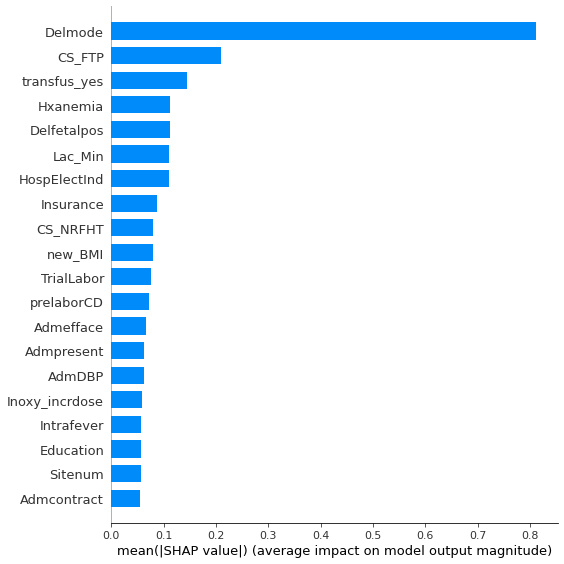

In [9]:
shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=20)

In [10]:
%%time
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=70, criterion="friedman_mse",max_depth=11, min_samples_leaf=50,
                                     min_samples_split=900,max_leaf_nodes=None,max_features=12,subsample=0.9,
                                     learning_rate=0.1,random_state=7)
#clf = GradientBoostingClassifier(n_estimators=70, criterion="friedman_mse",max_depth=11, min_samples_leaf=50,
#                                     min_samples_split=900,max_leaf_nodes=None,max_features=None,subsample=0.9,
#                                     learning_rate=0.1,random_state=7)
#stats_df = bootstrap_stat(X, y, clf, nsamples=100, under=True)
#stats_df, feats_df, X_train = bootstrap_stat(X, y, clf, nsamples=10, under=True)
stats_df, feats_df, X_train = bootstrap_stat(X, y, clf, sample_weights=True, nsamples=10, under=False)
stats_df.loc['mean'] = stats_df.mean()
stats_df.loc['mean',:]

CPU times: user 1min 50s, sys: 2.79 s, total: 1min 52s
Wall time: 1min 52s


recall      0.867593
prec        0.162685
MCC         0.322952
PR_AUC      0.284511
avg_prec    0.284833
roc_auc     0.894882
Name: mean, dtype: float64

In [11]:
feats_df['mean'] = feats_df.mean(axis=1)
feats_df.sort_values(by='mean', inplace=True, ascending=False)
feats_df.head(20)

,0,1,2,3,4,5,6,7,8,9,mean
Delmode,0.259474,0.239289,0.203578,0.245868,0.204172,0.259227,0.300283,0.257119,0.254106,0.161892,0.238501
CS_FTP,0.061404,0.071455,0.064190,0.090965,0.102370,0.050797,0.041945,0.056972,0.096079,0.085986,0.072216
TrialLabor,0.037615,0.048872,0.076924,0.046966,0.048412,0.052967,0.049273,0.041850,0.045043,0.045025,0.049295
Delfetalpos,0.043413,0.047175,0.059152,0.042498,0.045087,0.045493,0.048296,0.064141,0.042411,0.054752,0.049242
Lac_Min,0.032499,0.026990,0.027880,0.027261,0.037280,0.041489,0.027737,0.057689,0.023606,0.039531,0.034196
transfus_yes,0.032549,0.034774,0.032698,0.031496,0.034456,0.035805,0.031834,0.033032,0.033288,0.038262,0.033819
CS_NRFHT,0.029733,0.031388,0.018096,0.025078,0.014586,0.030680,0.024657,0.032073,0.026158,0.030048,0.026250
Admefface,0.012289,0.013980,0.020971,0.014637,0.045048,0.028397,0.023948,0.022932,0.013496,0.016712,0.021241
prelaborCD,0.035424,0.039413,0.018013,0.015303,0.018216,0.013422,0.020214,0.012274,0.020680,0.018016,0.021097
Hxcsection,0.027321,0.006172,0.011062,0.029588,0.008036,0.027229,0.004623,0.026416,0.041869,0.014068,0.019638


In [12]:
%%time
#explainer = shap.TreeExplainer(clf)
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_train)

CPU times: user 3min 24s, sys: 1.02 s, total: 3min 25s
Wall time: 3min 24s


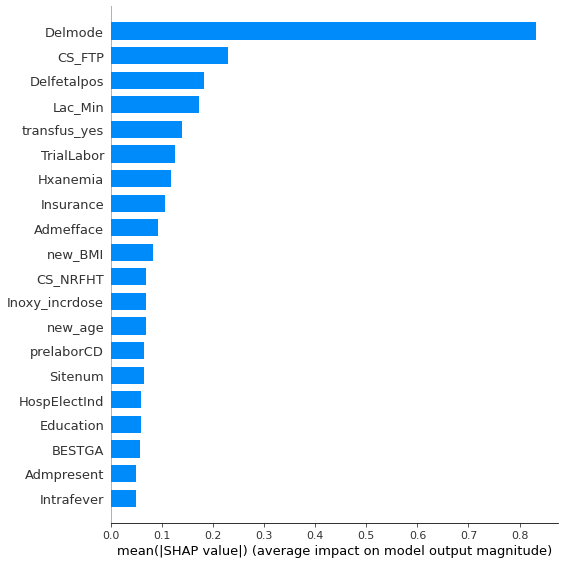

In [13]:
shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=20)

invalid value encountered in true_divide
invalid value encountered in true_divide


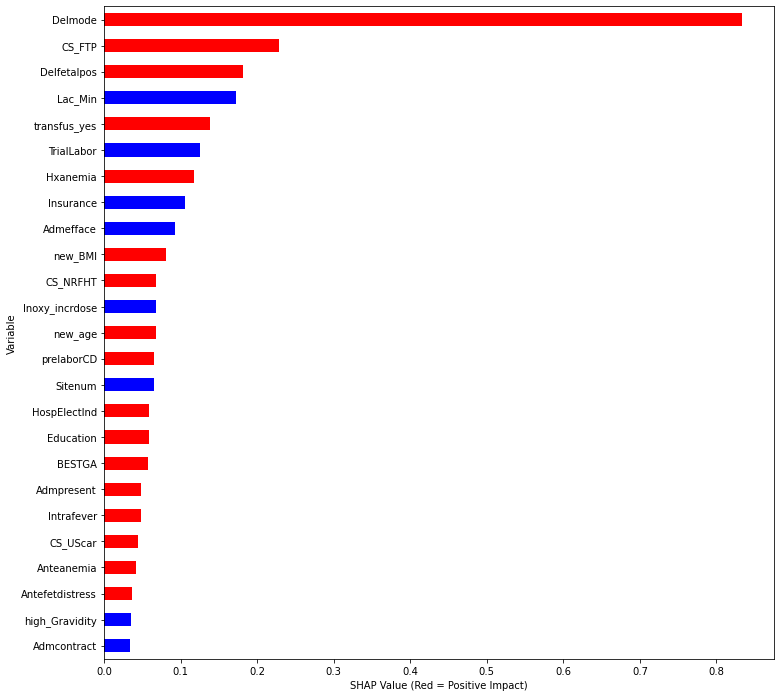

In [14]:
def ABS_SHAP(df_shap,df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    #df_v = df.copy().reset_index().drop('index',axis=1)
    df_v = df.copy()
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
#    colorlist = k2.iloc[46:66,:]['Sign']
#    print(k2.iloc[46:66,:])
#    ax = k2.iloc[46:66,:].plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(12,12),legend=False)
    colorlist = k2.tail(25)['Sign']
    ax = k2.tail(25).plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(12,12),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
ABS_SHAP(shap_values,X_train)

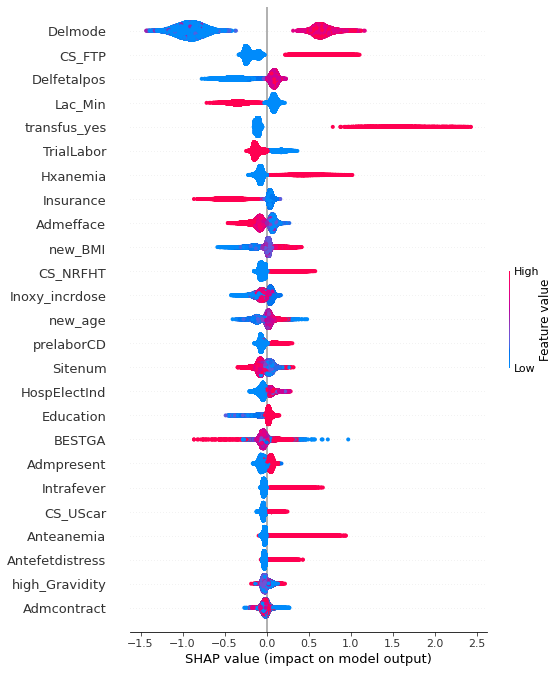

CPU times: user 14.1 s, sys: 176 ms, total: 14.2 s
Wall time: 14.2 s


In [15]:
%%time
shap.summary_plot(shap_values, X_train, max_display=25)

In [16]:
shap.initjs()
print(X_train.shape)

(95540, 196)


In [17]:
#print(X_train.iloc[500])
#shap.force_plot(explainer.expected_value, shap_values, X_train.iloc[500])
#print(X_train.shape)

ValueError: Passing parameters norm and vmin/vmax simultaneously is not supported. Please pass vmin/vmax directly to the norm when creating it.

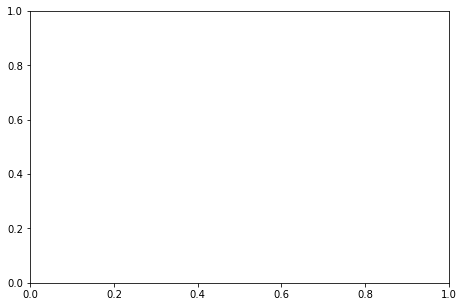

In [18]:
shap.dependence_plot("Inoxy_incrdose", shap_values, X_train, x_jitter=0.2)

In [ ]:
shap.dependence_plot("Delmode", shap_values, X_train, x_jitter=0.2)

In [ ]:
shap.dependence_plot("Inoxy_incrdose", shap_values, X_train, x_jitter=0.2, interaction_index='Intratocolytix')

In [ ]:
shap.dependence_plot("DMControl", shap_values, X_train, x_jitter=0.2)

In [ ]:
shap.dependence_plot("GAmethod", shap_values, X_train, x_jitter=0.2)

In [ ]:
shap.dependence_plot("GAmethod", shap_values, X_train, x_jitter=0.2, interaction_index='DMControl')

In [ ]:
shap.dependence_plot("HosEpiNurse", shap_values, X_train, x_jitter=0.2, interaction_index=None)

In [ ]:
shap.dependence_plot("HosEpiNurse", shap_values, X_train, x_jitter=0.2)

In [ ]:
shap.dependence_plot("Inoxy_incrdose", shap_values, X_train, x_jitter=0.2, interaction_index='Hostype')

In [ ]:
shap.dependence_plot("HosEpiNurse", shap_values, X_train, x_jitter=0.2)

In [ ]:
shap.dependence_plot("Education", shap_values, X_train, x_jitter=0.2)

In [ ]:
shap.dependence_plot("Hxanemia", shap_values, X_train, x_jitter=0.2)

In [ ]:
shap.dependence_plot("Inoxy_incrdose", shap_values, X_train, x_jitter=0.2, interaction_index='Sitenum')

In [ ]:
import matplotlib.pyplot as plt
#shap.dependence_plot("Sitenum", shap_values, X_train, x_jitter=0.2, interaction_index='Inoxy_incrdose')
shap.dependence_plot("Sitenum", shap_values, X_train, x_jitter=0.2, cmap=plt.get_cmap("Spectral"), interaction_index='Inoxy_incrdose')
## BAD shap.dependence_plot("Sitenum", shap_values, X_train, x_jitter=0.2, cmap=plt.get_cmap("Paired"), interaction_index='Inoxy_incrdose')
#shap.dependence_plot("Sitenum", shap_values, X_train, x_jitter=0.2, cmap=plt.get_cmap("plasma"), interaction_index='Inoxy_incrdose')

In [ ]:
shap.dependence_plot("Sitenum", shap_values, X_train, x_jitter=0.2, interaction_index=None)

In [ ]:
shap.dependence_plot("Sitenum", shap_values, X_train, x_jitter=0.2)

In [ ]:
shap.dependence_plot("Sitenum", shap_values, X_train, cmap=plt.get_cmap("plasma"), x_jitter=0.2)

In [ ]:
shap.dependence_plot("Intratocolytix", shap_values, X_train, x_jitter=0.3)

In [ ]:
shap.dependence_plot("Inoxy_incrdose", shap_values, X_train, x_jitter=0.5)

In [ ]:
shap.dependence_plot("Inoxy_incrdose", shap_values, X_train, x_jitter=0.2, interaction_index='Intratocolytix')

In [ ]:
shap.dependence_plot("Inoxy_incrdose", shap_values, X_train, x_jitter=0.2, interaction_index=None)

In [ ]:
shap.dependence_plot("Intratocolytix", shap_values, X_train, x_jitter=0.2, interaction_index=None)

In [ ]:
shap.dependence_plot("DMControl", shap_values, X_train, x_jitter=0.2, interaction_index=None)

In [ ]:
shap.dependence_plot("Delmode", shap_values, X_train, x_jitter=0.1, interaction_index=None)

In [ ]:
shap.dependence_plot("Education", shap_values, X_train, x_jitter=0.1, interaction_index=None)

In [ ]:
shap.dependence_plot("Hostype", shap_values, X_train, x_jitter=0.1)

In [ ]:
shap.dependence_plot("Inoxy_incrdose", shap_values, X_train, x_jitter=0.4, interaction_index='Hostype')

In [ ]:
shap.dependence_plot("Inoxy_incrdose", shap_values, X_train, x_jitter=0.4, interaction_index='Education')

In [ ]:
shap.dependence_plot("Inoxy_incrdose", shap_values, X_train, x_jitter=0.4, interaction_index='HosEpiNurse')

In [ ]:
shap.dependence_plot("Inoxy_incrdose", shap_values, X_train, x_jitter=0.4, interaction_index='Hxanemia')

In [ ]:
shap.dependence_plot("Inoxy_incrdose", shap_values, X_train, x_jitter=0.4, interaction_index='Intratocolytix')

In [ ]:
shap.dependence_plot("Inoxy_incrdose", shap_values, X_train, x_jitter=0.4, interaction_index='GAmethod')